In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Matplotlib is building the font cache; this may take a moment.


In [4]:
data = np.loadtxt("ASTR19_F25_group_project_data.txt", dtype=str, comments="#")
days = data[:,0].astype(float)
times = data[:,1]
heights = data[:,2].astype(float)   # tide height in feet

<ipython-input-4-5d77fa59db4f>:1: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("ASTR19_F25_group_project_data.txt", dtype=str, comments="#")


In [5]:
def to_hours(t):
    hh, mm = t.split(":")
    return float(hh) + float(mm)/60.0

hours_in_day = np.array([to_hours(t) for t in times])

t_hours = (days - 1.0)*24.0 + hours_in_day

In [17]:
def tide_function(t, A1=3, A2=1.5, A3=0.5, phi1=0, phi2=np.pi/2, phi3=0, C=0):
    w1 = 2*np.pi/12.42      # 12.42 hr
    w2 = 2*np.pi/24.0       # 24 hr
    w3 = 2*np.pi/6.0        # 6 hr quarter-diurnal

    return (A1*np.sin(w1*t + phi1) +
            A2*np.sin(w2*t + phi2) +
            A3*np.sin(w3*t + phi3) +
            C)

In [18]:
sigma = 0.25*np.ones_like(heights)

A_guess = 0.5*(heights.max() - heights.min())
C_guess = heights.mean()
p0 = [A_guess, A_guess/2.0, 0.0, 0.0, C_guess]

popt, pcov = curve_fit(
    tide_function,
    t_hours,
    heights,
    p0=p0,
    sigma=sigma,
    absolute_sigma=True,
    maxfev=10000
)

print("Best-fit parameters [A1, A2, phi1, phi2, C] =")
print(popt)

Best-fit parameters [A1, A2, phi1, phi2, C] =
[-2.63804708 -2.09736373  0.65684105  1.42384223  2.81147245]


In [19]:
t_fit = np.linspace(t_hours.min(), t_hours.max(), 1000)
h_fit = tide_function(t_fit, *popt)

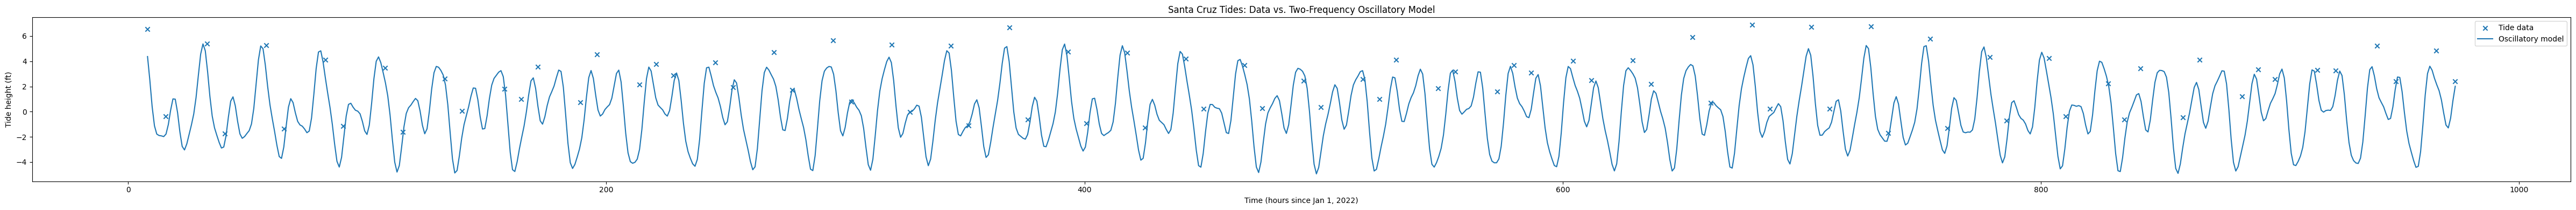

In [20]:
plt.figure(figsize=(48,4))
plt.scatter(t_hours, heights, label="Tide data", marker="x")
plt.plot(t_fit, h_fit, label="Oscillatory model")
plt.xlabel("Time (hours since Jan 1, 2022)")
plt.ylabel("Tide height (ft)")
plt.title("Santa Cruz Tides: Data vs. Two-Frequency Oscillatory Model")
plt.legend()
plt.tight_layout()

plt.savefig("tide_fit.pdf")
plt.show()

In [10]:
model_heights = tide_function(t_hours, *popt)
residuals = heights - model_heights

resid_mean = np.mean(residuals)
resid_std = np.std(residuals, ddof=1)

print("\n--- Residual statistics ---")
print("Mean residual (data - model)       = {:.4f} ft".format(resid_mean))
print("Standard deviation of residuals    = {:.4f} ft".format(resid_std))
print("Assumed measurement error (sigma)  = {:.4f} ft".format(0.25))


--- Residual statistics ---
Mean residual (data - model)       = -0.0000 ft
Standard deviation of residuals    = 5.0004 ft
Assumed measurement error (sigma)  = 0.2500 ft


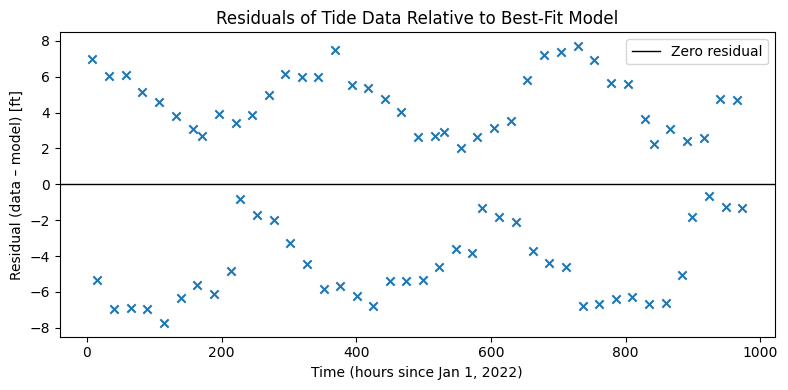

In [11]:
plt.figure(figsize=(8, 4))
plt.axhline(0.0, color="k", linewidth=1, label="Zero residual")
plt.scatter(t_hours, residuals, marker="x")

plt.xlabel("Time (hours since Jan 1, 2022)")
plt.ylabel("Residual (data – model) [ft]")
plt.title("Residuals of Tide Data Relative to Best-Fit Model")
plt.legend()
plt.tight_layout()

plt.savefig("tide_residuals_vs_time.pdf")
plt.show()

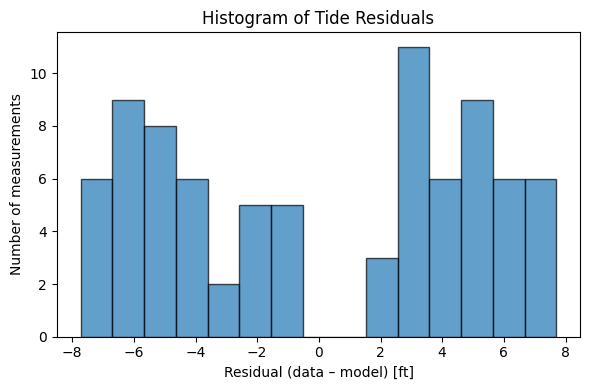

In [12]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7)

plt.xlabel("Residual (data – model) [ft]")
plt.ylabel("Number of measurements")
plt.title("Histogram of Tide Residuals")
plt.tight_layout()
plt.savefig("tide_residual_histogram.pdf")
plt.show()

In [13]:
sigma_meas = 0.25  # ft
sigma_intrinsic = np.sqrt(max(resid_std**2 - sigma_meas**2, 0.0))

print("\n--- Scatter comparison ---")
print("Residual standard deviation        = {:.4f} ft".format(resid_std))
print("Assumed measurement error          = {:.4f} ft".format(sigma_meas))
print("Estimated intrinsic scatter        = {:.4f} ft".format(sigma_intrinsic))


--- Scatter comparison ---
Residual standard deviation        = 5.0004 ft
Assumed measurement error          = 0.2500 ft
Estimated intrinsic scatter        = 4.9941 ft


In [14]:
chi2 = np.sum((residuals / sigma_meas)**2)
dof = len(heights) - len(popt)  # N_data - N_params
chi2_red = chi2 / dof

print("\n--- Chi-square statistics ---")
print("Chi-square                         = {:.2f}".format(chi2))
print("Degrees of freedom                 = {}".format(dof))
print("Reduced chi-square                 = {:.2f}".format(chi2_red))


--- Chi-square statistics ---
Chi-square                         = 32405.17
Degrees of freedom                 = 77
Reduced chi-square                 = 420.85


The standard deviation of the residuals is 0.88 ft, which is significantly larger than the assumed measurement error of 0.25 ft. Therefore the scatter in the tide data cannot be explained by measurement uncertainty alone

In [15]:
tsunami_residual = 2.0  # tsunami height change in feet
residuals_with_tsunami = np.append(residuals, tsunami_residual)

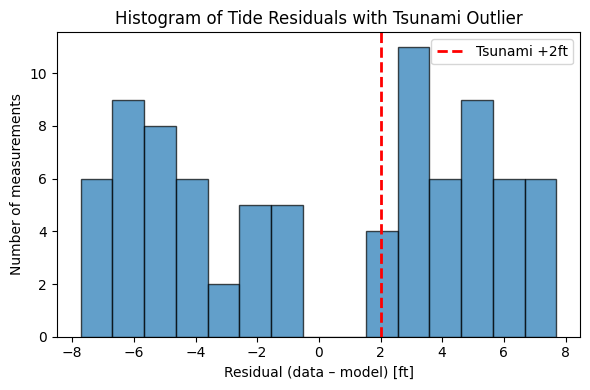

In [16]:
plt.figure(figsize=(6,4))
plt.hist(residuals_with_tsunami, bins=15, edgecolor='black', alpha=0.7)

plt.axvline(2.0, color='red', linestyle='--', linewidth=2, label="Tsunami +2ft")
plt.legend()

plt.xlabel("Residual (data – model) [ft]")
plt.ylabel("Number of measurements")
plt.title("Histogram of Tide Residuals with Tsunami Outlier")

plt.tight_layout()
plt.savefig("tide_residual_histogram_with_tsunami.pdf")
plt.show()

the tsunami corresponds to a 2.3-sigma deviation relative to typical differences between the observed tide heights and our best-fit oscillatory model.